# Investigate impacts from the wording of Federal Reserve (Fed) meetings to financial market.

The objective of this project is to apply NLP on those texts published by FOMC to attempt to
quantify the communications in a systematic manner and find the relationship with Treasury
yield curve.

# Table of Contents


1. [Data Overview](#data-o)
    <br>1.1 [Summary](#sum)
    <br>1.2 [Sections](#t-sect)
    <br>1.3 [Crop Sections](#crop)

2. [Data Pre-processing](#data-p)
    <br>2.1 [Tokenization](#stemlem)

3. [Topic Modelling](#topic-m)
    <br>3.1 [Non-negative Matrix Factorization](#nmf)
    <br>3.2 [Latent Dirichlet Allocation](#lda)
 
4. [Sentiment Analysis](#sent-a)
    <br>4.1 [Dictionary Approach](#dict)
    <br>4.2 [Sentiment Extraction](#sent-e)
    
5. [Modeling](#model)
    <br>5.1 [Sentiment Correlations and Baseline Model](#base)
    <br>5.2 [BERT and CNN Model](#bert)







In [1]:
file_path_prefix = None

In [2]:
#if using colab
from google.colab import drive
drive.mount('/content/drive')
!pip install -r drive/My\ Drive\/fednlp/requirements.txt
file_path_prefix = './drive/My Drive/fednlp/data/'

ModuleNotFoundError: No module named 'google'

In [3]:
import re
import os,sys
import calendar
import datetime
from datetime import timedelta
from collections import Counter
import pickle

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import CategorizedPlaintextCorpusReader
from wordcloud import WordCloud
import spacy
from spacy.lang.en import English
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer


if file_path_prefix is None:
    file_path_prefix = '/Users/aaroncgw/Google_Drive_harvard/fednlp/data/'

nltk.download('punkt')

!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()

[nltk_data] Downloading package punkt to /Users/aaroncgw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


You are using pip version 19.0.3, however version 20.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


# <a name="data-o"></a> Data Overview
Data was web scrapped from https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm.
The year 2004 was chosen as the start-year given the acceleration of release dates to 3 weeks, and improved clarity in explanations of committee’s decisions and views [(Danker,2005)](https://www.federalreserve.gov/pubs/bulletin/2005/spring05_fomc.pdf)

## <a name="sum"></a>Minutes Summary

In [4]:
corpus_root = file_path_prefix + 'minutes'
data_m = CategorizedPlaintextCorpusReader(corpus_root, r'.*\.txt', cat_pattern=r'(\w+)/*')
data_fileids = data_m.fileids()

print('Total number of files: '+str(len(data_m.fileids())))
print('Number of paragraphs: '+str(len(data_m.paras())))
print('Number of sentences: '+str(len(data_m.sents())))
print('Number of words: '+str(len(data_m.words())))
print('\n'+'First file: '+ data_fileids[0])
print('Last file: '+ data_fileids[-1])

Total number of files: 130
Number of paragraphs: 15852
Number of sentences: 41024
Number of words: 1114443

First file: 2004/20040128.txt
Last file: 2020/20200429.txt


<AxesSubplot:xlabel='index', ylabel='Average number of words'>

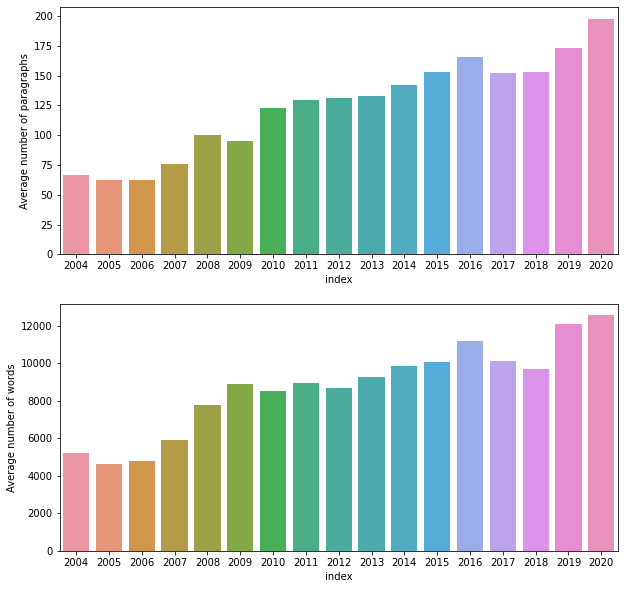

In [5]:
num_para_py = {}
num_word_py = {}

for y in range(2004,2021):
    files = data_m.fileids(str(y))
    files_size = len(files)
    num_para_py[y] = sum([len(data_m.paras(f))for f in files])/files_size
    num_word_py[y] = sum([len(data_m.words(f))for f in files])/files_size
        
para_words = pd.DataFrame([num_para_py,num_word_py],
                          index = ['Average number of paragraphs','Average number of words']).T

para_words = para_words.reset_index()

fig,ax = plt.subplots(2, 1, figsize=(10,10))
sns.barplot(x="index", y="Average number of paragraphs", data=para_words, ax=ax[0])
sns.barplot(x="index", y="Average number of words", data=para_words, ax=ax[1])

We can see an acceleration in the amount of paragraphs and words overtime.

## <a name="t-sect"></a> Sections
The minutes are split into 4 sections (see [Background on FOMC Meeting Minutes](https://www.federalreserve.gov/pubs/bulletin/2005/spring05_fomc.pdf)) 

1. Introduction
2. Economic and financial information
3. Participants’ views on developments 
4. Policy decisions

The first set of introductory paragraphs contain a list of attendees and procedural items, which are not of use to our analysis and hence need to be removed. The next problem to tackle is knowing when to start the minutes from.

Text(0, 0.5, 'Word count')

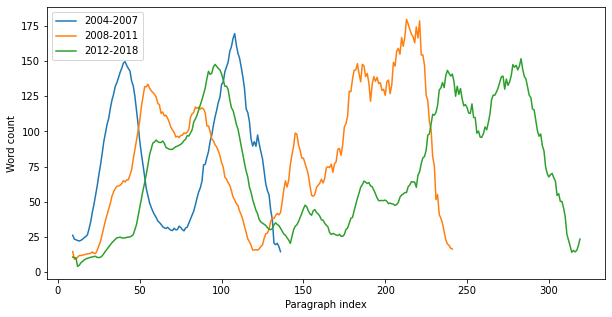

In [6]:
df_temp = pd.DataFrame()
df_year = pd.DataFrame()
for y in range(2004,2019):
    files = data_m.fileids(str(y))
    for f in files:
        word_para = [sum([len(s)for s in p]) for p in data_m.paras(f)]
        df_temp = pd.concat([df_temp,pd.Series(word_para,name=f)],axis=1)
    
    df_mean = df_temp.mean(axis=1)
    df_mean.name = y
    df_year= pd.concat([df_year,df_mean],axis=1)
    df_temp = df_temp.iloc[0:0]

window_size = 10

y1 = df_year.loc[:,[y for y in range(2004,2008)]].mean(axis=1).rolling(window_size).mean()
y2 = df_year.loc[:,[y for y in range(2009,2012)]].mean(axis=1).rolling(window_size).mean()
y3 = df_year.loc[:,[y for y in range(2012,2019)]].mean(axis=1).rolling(window_size).mean()

df_joint = pd.DataFrame([y1,y2,y3],index = ['2004-2007','2008-2011','2012-2018']).T


ax = df_joint.plot(figsize=(10,5))
ax.set_xlabel("Paragraph index")
ax.set_ylabel("Word count")

To see how the mintues are structured, we can plot a moving average of words per paragraph. The peaks and troughs of this moving average are indicative of new sections, where usually the start of the section includes a header or a very few words. 

For simplicity, I've identified three different types of structures that span from 2004-2007, 2008-2011 and 2012-2018. It is quite clear that the early minutes (2004-2007) began it's second section by paragraph 30-40, whilst those minutes later on began around paragraph 50 onwards.
  

## <a name="crop"></a>Crop Sections

Given that we know where sections roughly start, the easiest way to split our sections is to find the most common words. For our analysis, the minutes will start with phrases similar to 'Staff Review of the Economic Situation' or 'The information reviewed' and end on 'At the conclusion of this meeting' or 'The Committee voted to authorize'.

In [7]:
corpus_root_cropped = file_path_prefix + 'minutes_cropped'
data_c = CategorizedPlaintextCorpusReader(corpus_root_cropped, r'.*\.txt', cat_pattern=r'(\w+)/*')

print('Total number of files: '+str(len(data_c.fileids())))
print('Number of paragraphs: '+str(len(data_c.paras())))
print('Number of sentences: '+str(len(data_c.sents())))
print('Number of words: '+str(len(data_c.words())))

Total number of files: 130
Number of paragraphs: 5368
Number of sentences: 24029
Number of words: 726903


Total number of paragraphs, sentences and words have been reduced by 30-60%.

## <a name="rates"></a>Treasury Rates

In [53]:
with open(file_path_prefix + 'rates/rates_daily.pickle', 'rb') as handle:
    rates_daily = pickle.load(handle)
    
with open(file_path_prefix + 'rates/rates_monthly.pickle', 'rb') as handle:
    rates_monthly = pickle.load(handle)

In [55]:
df_yc_slope_changes = pd.DataFrame((rates_monthly['BC_10YEAR'] - rates_monthly['BC_3MONTH']), columns=['slope_change']).diff().shift(-1)[:-1]
df_yc_slope_changes['steepen'] = df_yc_slope_changes['slope_change'] > 0
df_yc_slope_changes


,slope_change,steepen
date,,
1990-01-31,0.16,True
1990-02-28,-0.05,False
1990-03-31,0.33,True
1990-04-30,0.00,False
1990-05-31,-0.26,False
...,...,...
2020-02-29,0.61,True
2020-03-31,-0.05,False
2020-04-30,0.02,True


# <a name="data-p"></a> Data Pre-processing



## <a name="stemlem"></a> Tokenization

To enhance topic modelling output, we can remove stop words and reduce inflectional forms of words back to its roots - using techniques such as stemming and lemmatization. 


In [10]:
en = English()

def simple_tokenizer(doc, model=en):
    tokenized_docs = []
    parsed = model(doc)
    return([t.lemma_.lower() for t in parsed if (t.is_alpha)&(not t.like_url)&(not t.is_stop)])

In [97]:
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)  # this will never fail
    return next_month - datetime.timedelta(days=next_month.day)

In [101]:
idx = []
para_number = []
paragraph_list = []
for f in data_c.fileids():
    year,month,day = re.search("(\d{4})(\d{2})(\d{2})",f).groups()
    for i,p in enumerate(data_c.paras(f)):
        idx.append((last_day_of_month(datetime.datetime(int(year), int(month), int(day))), i)) #Year,Month,Day,Paragraph number
        flat_p = [item for sublist in p for item in sublist]
        paragraph = ' '.join(flat_p)
        p_tokenized = simple_tokenizer(paragraph)
        paragraph_list.append([p_tokenized,flat_p])

df_paragraphs = pd.DataFrame(data = paragraph_list,
                          index = pd.MultiIndex.from_tuples(idx), 
                          columns = ['tokenized_text','old_text'])

df_paragraphs.head()

tokenized_text  \
2004-01-31 0  [committee, turned, discussion, economic, outl...   
           1  [economy, appeared, expanded, robust, pace, fo...   
           2  [december, employment, report, suggested, labo...   
           3  [pace, expansion, industrial, sector, picked, ...   
           4  [sales, light, vehicles, jumped, december, fou...   

                                                       old_text  
2004-01-31 0  [The, Committee, then, turned, to, a, discussi...  
           1  [The, economy, appeared, to, have, expanded, a...  
           2  [The, December, employment, report, suggested,...  
           3  [The, pace, of, expansion, in, the, industrial...  
           4  [Sales, of, light, vehicles, jumped, in, Decem...

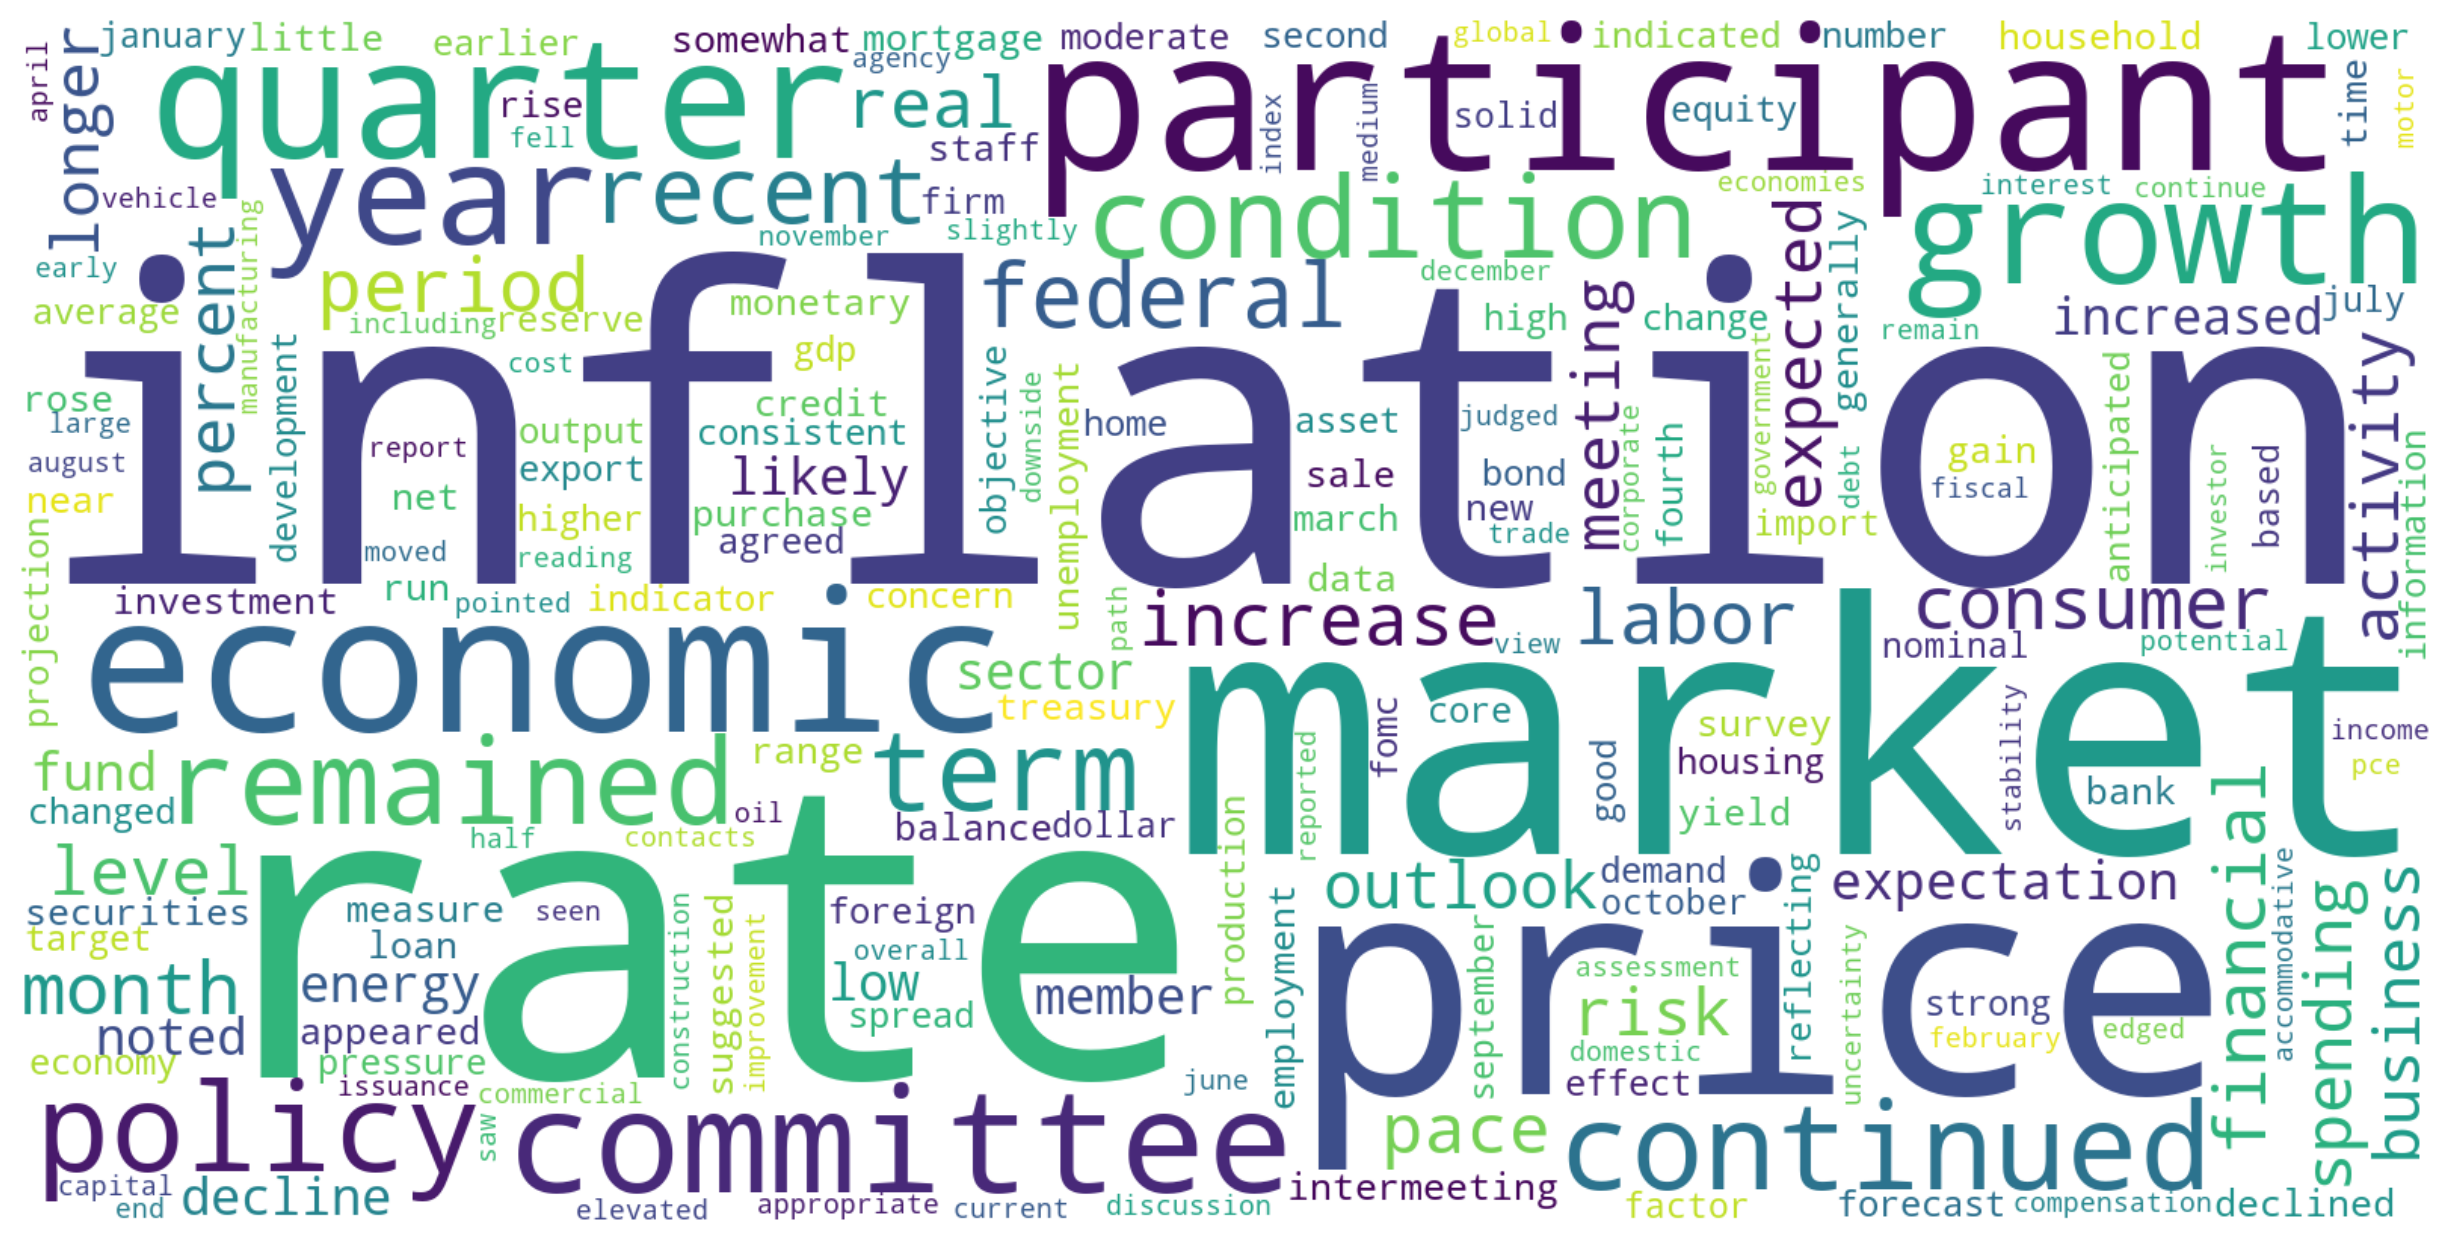

In [12]:
#Most frequent words in corpus
tokenized_text = df_paragraphs['tokenized_text']
all_tokens = [item for sublist in tokenized_text for item in sublist]

wordcloud = WordCloud(collocations=False,
                      background_color='white',
                      mode='RGB',
                      width=1600, height=800).generate((" ").join(all_tokens))

fig = plt.figure(figsize=(16,8),dpi=200)
plt.axis('off')
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

# <a name="topic-m"></a>Topic Modelling 

Now that we have our clean text corpus, we can create a bag of words and pass it into a Latent Dirichlet Allocation model (LDA). This probabilistic model is ideal for our analysis as each paragraph is distributed amongst a set of topics, where topics themselves are defined by words that frequently appear with each other. 

<br>
In our previous example, the phrase "Labor market conditions continued to strengthen in recent months, with the unemployment rate declining further and payroll gains well above a pace consistent with maintaining a stable unemployment rate over time" is one that belongs in the labour market category. Additionally, one might say words like labour, payroll and unemployment are more likely to appear in the same document (or in this case paragraph). 

In [84]:
def summarize_topics(model, feature_names, no_top_words):
    topics = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i]for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics["Topic %d:" % (topic_idx)] = top_words
    return topics

num_topics = 6

## <a name="lda"></a>LDA

One of the most important inputs in the LDA model is the number of topics (n_components). Given that this is an unsupervised task, there is no best way to choose this input other than trial and error - which in this case results to n_components = 6. 

In [85]:
count_vecs = CountVectorizer(tokenizer = lambda x: x, lowercase = False)
count_vecs_fitted = count_vecs.fit_transform(list(tokenized_text))

lda = LatentDirichletAllocation(n_components = num_topics, random_state =7).fit(count_vecs_fitted)
lda_t = lda.transform(count_vecs_fitted)

df_paragraphs['topic_weights'] = list(lda_t)

lda_topic_top_words = summarize_topics(lda,count_vecs.get_feature_names(),10)
lda_topic_top_words

,Topic 0:,Topic 1:,Topic 2:,Topic 3:,Topic 4:,Topic 5:
0,labor,federal,period,inflation,quarter,growth
1,rate,committee,credit,participants,consumer,economic
2,unemployment,reserve,intermeeting,economic,spending,participants
3,employment,s,market,committee,real,staff
4,production,financial,yields,policy,prices,activity
5,months,policy,loans,rate,sales,gdp
6,manufacturing,securities,remained,s,business,real
7,average,purchases,financial,market,months,s
8,year,rate,treasury,percent,remained,prices
9,output,funds,rates,expectations,continued,expected


The output above shows the top 10 words associated to each topic. Some topics are more distinguishable than others, where words such as inflation, price, energy are usually associated to the topic 'Inflation', whilst others are less so.

In [86]:
#Dictionary with topics
topic_dict = {0 : 'Labor Market',
              1 : 'Policy',
              2 : 'Financial Market', 
              3 : 'Inflation',
              4 : 'Outlook', 
              5 : 'Investment'}
topic_dict

{0: 'Labor Market',
 1: 'Policy',
 2: 'Financial Market',
 3: 'Inflation',
 4: 'Outlook',
 5: 'Investment'}

In [88]:
def sum_prop(x):
    x_sum = x.sum(axis=0)
    return (x_sum/x_sum.sum())*100

df_topic_t = df_paragraphs.groupby(level=[0],sort=False)['topic_weights']\
                        .apply(lambda x: sum_prop(x)).apply(pd.Series)\
                        .rename(columns = topic_dict)

df_topic_m = df_topic_t.groupby(level=[0],sort=False).apply(lambda x: sum_prop(x))
topic_perc = df_topic_m.divide(df_topic_m.sum(axis=1), axis=0)

In [89]:
df_topic_m.head()

,Labor Market,Policy,Financial Market,Inflation,Outlook,Investment
2004-01-28,14.084471,8.819738,6.785797,24.264094,28.134304,17.911596
2004-03-16,11.399041,7.952045,7.307960,19.988979,31.097181,22.254794
2004-05-04,14.324069,7.461679,6.491771,22.744897,28.931485,20.046100
2004-06-30,10.768447,9.230299,5.347256,22.146268,31.001017,21.506713
2004-08-10,14.134293,8.252674,3.907643,21.312169,29.133144,23.260077


Text(0.5, 1.0, 'Topic Percentage Over Time')

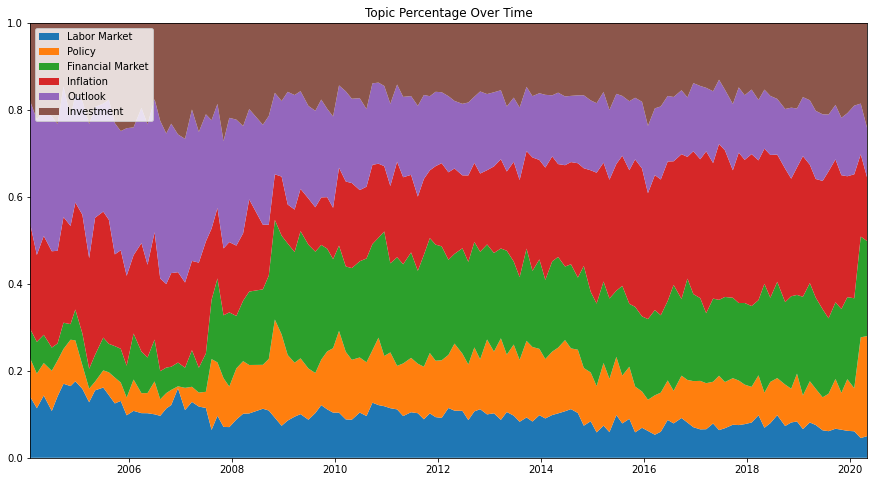

In [91]:
fig, ax = plt.subplots(figsize=(15,8))
ax.stackplot(df_topic_m.index,  topic_perc["Labor Market"],  topic_perc["Policy"],  topic_perc["Financial Market"], 
              topic_perc["Inflation"],  topic_perc["Outlook"],  topic_perc["Investment"],
              labels=['Labor Market','Policy','Financial Market', 'Inflation', 'Outlook', 'Investment'])
ax.legend(loc='upper left')
ax.margins(0,0)
ax.set_title('Topic Percentage Over Time')

As expected the topic 'Financial markets' increased in proportion after 2008. To date, the largest topic is 'Policy' and the smallest is 'Labor Market'. 

# <a name="sent-a"></a> Sentiment Analysis 

Two sets of dictionaries were used in this section: 
1. Havard IV-4 Psychosociological 
2. Loughran and McDonald

The former is less tailored to financial statements, whilst Loughran and McDonald is adapted to include words from 10-K documents.

Given the lack of labelled data, a very simplistic approach is used to calculate sentiment tone: 

\begin{equation*}
Net \ Tone \  = \frac{\#Positive\ words - \#Negative\ words}
                    {\#Positive\ words + \#Negative\ words} \times \frac{1}{\#Total\ words}
\end{equation*}

Where <br>

Net tone > 0 points to a positive tone
<br>
Net tone < 0 points to a negative tone
<br>
Net tone = 0 points to neutral tone


##  <a name="dict"></a> Dictionary Approach 

Text(0.5, 1.0, 'top negative words')

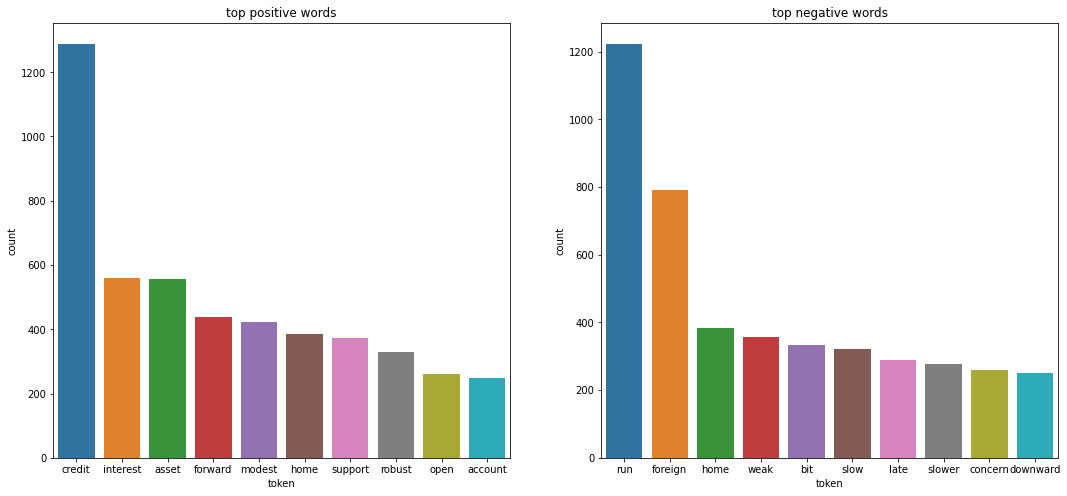

In [92]:
with open(file_path_prefix + 'sentiment/sentiment_pos_dict.pickle', 'rb') as handle:
    posDict = pickle.load(handle)
    
with open(file_path_prefix + 'sentiment/sentiment_neg_dict.pickle', 'rb') as handle:
    negDict = pickle.load(handle)


corpus_wcount = Counter([item for sublist in tokenized_text for item in sublist])
pos_inter = Counter({w:corpus_wcount[w] for w in posDict.intersection(corpus_wcount)})
neg_inter = Counter({w:corpus_wcount[w] for w in negDict.intersection(corpus_wcount)})

top_pos = pos_inter.most_common(10)
top_neg = neg_inter.most_common(10)

df_top_pos = pd.DataFrame(top_pos, columns=['token', 'count'])
df_top_neg = pd.DataFrame(top_neg, columns=['token', 'count'])

fig, ax = plt.subplots(1,2, figsize=(18,8))
sns.barplot(x="token", y="count", data=df_top_pos, ax=ax[0])
ax[0].set_title('top positive words')
sns.barplot(x="token", y="count", data=df_top_neg, label='top negative words', ax=ax[1])
ax[1].set_title('top negative words')

These are the top 10 positive and negative words that appear in the corpus. 

In [93]:
print("Number of positive words in corpus: " +str(sum(pos_inter.values())))
print("Number of negative words in corpus: " +str(sum(neg_inter.values())))

Number of positive words in corpus: 11135
Number of negative words in corpus: 9135


## <a name="sent-e"></a> Sentiment Extraction

In [94]:
def RetrieveScore(tokenized_para,positive,negative): 
    pos_sum = 0
    neg_sum = 0
    score = 0
    if len(tokenized_para) <8:
        return 0
    for word in tokenized_para: 
        if word in positive:
            pos_sum +=1
        elif word in negative:
            neg_sum +=1
    try:
        score = ((pos_sum-neg_sum)/(pos_sum+neg_sum))*(1/len(tokenized_para)) #should this be 
    except ZeroDivisionError:
        score = 0
    return score

df_paragraphs['sentiment_score'] = df_paragraphs.apply(lambda x: RetrieveScore(x['tokenized_text'],posDict,negDict),axis=1)
df_paragraphs


paragragh_number  \
2004-01-28 0                  0   
           1                  1   
           2                  2   
           3                  3   
           4                  4   
...                         ...   
2020-04-29 47                47   
           48                48   
           49                49   
           50                50   
           51                51   

                                                  tokenized_text  \
2004-01-28 0   [committee, turned, discussion, economic, outl...   
           1   [economy, appeared, expanded, robust, pace, fo...   
           2   [december, employment, report, suggested, labo...   
           3   [pace, expansion, industrial, sector, picked, ...   
           4   [sales, light, vehicles, jumped, december, fou...   
...                                                          ...   
2020-04-29 47  [discussion, monetary, policy, meeting, member...   
           48  [members, concurred, ongoing, public, health, ...   
           49  [members, agreed, continue, monitor, implicati...   
           50  [support, flow, credit, households, businesses...   
           51  [conclusion, discussion, committee, voted, aut...   

                                                        old_text  \
2004-01-28 0   [The, Committee, then, turned, to, a, discussi...   
           1   [The, economy, appeared, to, have, expanded, a...   
           2   [The, December, employment, report, suggested,...   
           3   [The, pace, of, expansion, in, the, industrial...   
           4   [Sales, of, light, vehicles, jumped, in, Decem...   
...                                                          ...   
2020-04-29 47  [In, their, discussion, of, monetary, policy, ...   
           48  [Members, further, concurred, that, the, ongoi...   
           49  [Members, agreed, that, they, would, continue,...   
           50  [To, support, the, flow, of, credit, to, house...   
           51  [At, the, conclusion, of, the, discussion, ,, ...   

                                                   topic_weights  \
2004-01-28 0   [0.015266202220822278, 0.015302447802623773, 0...   
           1   [0.1627823811669378, 0.0023561225001566713, 0....   
           2   [0.9933341079900678, 0.0013276585587196897, 0....   
           3   [0.9142093632638105, 0.0020619846211875647, 0....   
           4   [0.002636018910999324, 0.0026549378641340733, ...   
...                                                          ...   
2020-04-29 47  [0.0022536051492877377, 0.3156911629043188, 0....   
           48  [0.0031048952243318173, 0.003125418188692772, ...   
           49  [0.002325056870696752, 0.002344337398904747, 0...   
           50  [0.0032129111983774526, 0.9519608314852175, 0....   
           51  [0.027777787589893063, 0.35150246683054737, 0....   

               sentiment_score  
2004-01-28 0          0.000000  
           1          0.000000  
           2         -0.001600  
           3          0.000000  
           4          0.015873  
...                        ...  
2020-04-29 47         0.004505  
           48         0.018868  
           49         0.014085  
           50         0.019608  
           51         0.000000  

[5368 rows x 5 columns]

/Users/aaroncgw/Google_Drive_harvard/fednlp/env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/aaroncgw/Google_Drive_harvard/fednlp/env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/aaroncgw/Google_Drive_harvard/fednlp/env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/aaroncgw/Google_Drive_harvard/fednlp/env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/conve

<AxesSubplot:>

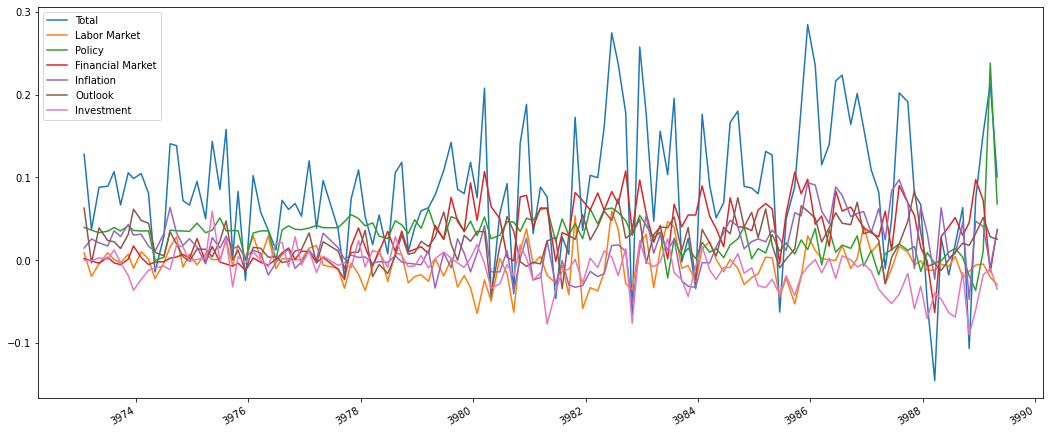

In [96]:
df_sentiment = (df_paragraphs['sentiment_score']*df_paragraphs['topic_weights']).apply(pd.Series).rename(columns = topic_dict)
df_sentiment = pd.concat([df_sentiment.sum(axis=1).rename('Total'),df_sentiment],axis=1)
df_sentiment_m = df_sentiment.groupby(level = [0],sort=False).apply(lambda x: x.sum())
df_sentiment_m.plot(figsize=(18,8))

The downside of using such a simplistic approach in calculating sentiment is that you can produce some anomalies, in particular for the 'inflation' topic. The word 'inflation' is negative but context is very important when classifying sentiment - in this case the sentence 'Inflation slowed down' should be a positive phrase but is classified as negative. Nevertheless, we can see see a joint dip amongst all topics in 2008, relating to the financial crisis. 

In [99]:
df_paragraphs.head()

paragragh_number  \
2004-01-31 0                 0   
           1                 1   
           2                 2   
           3                 3   
           4                 4   

                                                 tokenized_text  \
2004-01-31 0  [committee, turned, discussion, economic, outl...   
           1  [economy, appeared, expanded, robust, pace, fo...   
           2  [december, employment, report, suggested, labo...   
           3  [pace, expansion, industrial, sector, picked, ...   
           4  [sales, light, vehicles, jumped, december, fou...   

                                                       old_text  
2004-01-31 0  [The, Committee, then, turned, to, a, discussi...  
           1  [The, economy, appeared, to, have, expanded, a...  
           2  [The, December, employment, report, suggested,...  
           3  [The, pace, of, expansion, in, the, industrial...  
           4  [Sales, of, light, vehicles, jumped, in, Decem...

In [104]:

timestamps = df_paragraphs.index.map(lambda x: str(x[0]))
paragragh_numbers = df_paragraphs.index.map(lambda x: str(x[1]))
#unstacked_idx = [last_day_of_month(pd.to_datetime(i, format="%Y%b")) for i in idx]
df_paragraphs['paragragh_number'] = paragragh_numbers
df_paragraphs.index = timestamps

In [105]:
df_paragraphs = df_paragraphs.join(df_yc_slope_changes)
df_paragraphs

,tokenized_text,old_text,paragragh_number,slope_change,steepen
2004-01-31,"[committee, turned, discussion, economic, outl...","[The, Committee, then, turned, to, a, discussi...",0,-0.11,False
2004-01-31,"[economy, appeared, expanded, robust, pace, fo...","[The, economy, appeared, to, have, expanded, a...",1,-0.11,False
2004-01-31,"[december, employment, report, suggested, labo...","[The, December, employment, report, suggested,...",2,-0.11,False
2004-01-31,"[pace, expansion, industrial, sector, picked, ...","[The, pace, of, expansion, in, the, industrial...",3,-0.11,False
2004-01-31,"[sales, light, vehicles, jumped, december, fou...","[Sales, of, light, vehicles, jumped, in, Decem...",4,-0.11,False
...,...,...,...,...,...
2020-04-30,"[discussion, monetary, policy, meeting, member...","[In, their, discussion, of, monetary, policy, ...",47,0.02,True
2020-04-30,"[members, concurred, ongoing, public, health, ...","[Members, further, concurred, that, the, ongoi...",48,0.02,True
2020-04-30,"[members, agreed, continue, monitor, implicati...","[Members, agreed, that, they, would, continue,...",49,0.02,True
2020-04-30,"[support, flow, credit, households, businesses...","[To, support, the, flow, of, credit, to, house...",50,0.02,True


## <a name="rates"></a> Sentiment Correlations

In [56]:
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)  # this will never fail
    return next_month - datetime.timedelta(days=next_month.day)
    
df_sentiment_monthly = df_sentiment_m.copy()
idx = df_sentiment_monthly.index.map(lambda x: ''.join((str(x[0]), x[1])))
unstacked_idx = [last_day_of_month(pd.to_datetime(i, format="%Y%b")) for i in idx]
df_sentiment_monthly.index = unstacked_idx

combined_df = df_sentiment_monthly.join(df_yc_slope_changes.slope_change)
combined_df.corr()

,Total,Labor Market,Policy,Financial Market,Inflation,Outlook,Investment,slope_change
Total,1.000000,0.512334,0.292935,0.517570,0.537735,0.580397,0.425600,-0.029630
Labor Market,0.512334,1.000000,-0.056981,0.019425,0.284619,0.135187,0.247683,-0.035899
Policy,0.292935,-0.056981,1.000000,-0.093165,-0.228496,0.012095,0.275522,0.112009
Financial Market,0.517570,0.019425,-0.093165,1.000000,0.167734,0.281417,-0.141979,-0.071894
Inflation,0.537735,0.284619,-0.228496,0.167734,1.000000,0.237150,-0.006795,-0.120741
Outlook,0.580397,0.135187,0.012095,0.281417,0.237150,1.000000,0.036946,-0.026553
Investment,0.425600,0.247683,0.275522,-0.141979,-0.006795,0.036946,1.000000,0.091483
slope_change,-0.029630,-0.035899,0.112009,-0.071894,-0.120741,-0.026553,0.091483,1.000000


In [58]:
print(scipy.stats.pearsonr(combined_df['Total'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Labor Market'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Policy'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Financial Market'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Inflation'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Outlook'], combined_df['slope_change']))
print(scipy.stats.pearsonr(combined_df['Investment'], combined_df['slope_change']))

(-0.029629852459760568, 0.7378944486230906)
(-0.03589854875863089, 0.6851217645443027)
(0.11200896589162722, 0.2045263547967136)
(-0.07189397506658775, 0.4163023279858182)
(-0.12074106097887671, 0.17119453769874066)
(-0.026552878690565346, 0.7642700101923943)
(0.0914833734726804, 0.30058984703559627)


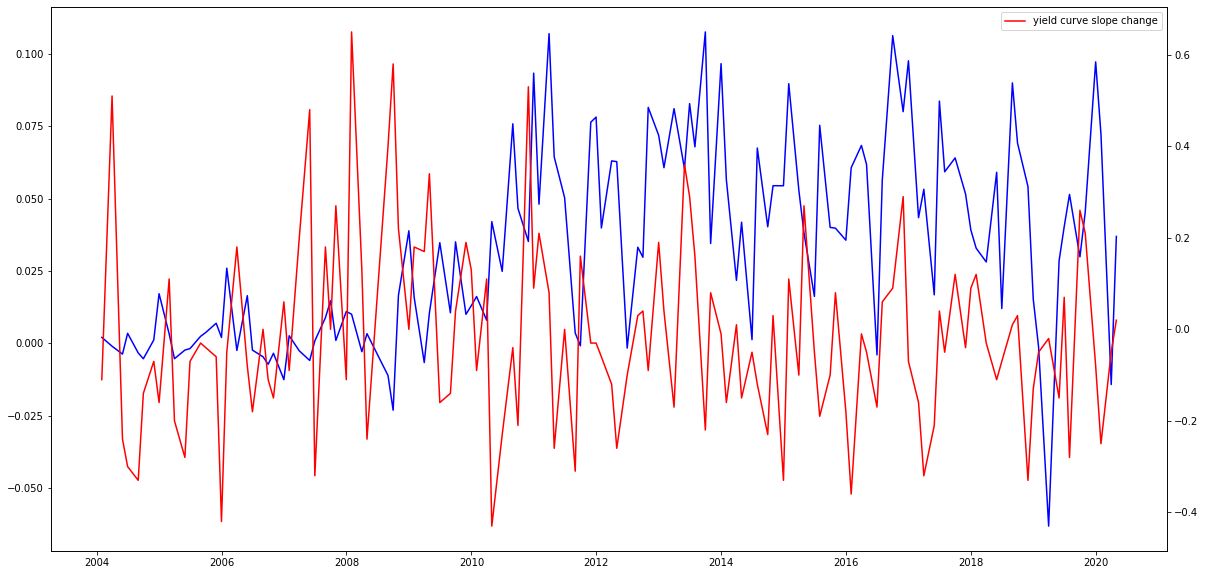

In [61]:
fig, ax_left = plt.subplots(figsize=(20,10))
ax_right = ax_left.twinx()

ax_left.plot(combined_df['Financial Market'], color='blue', label='Financial Market')
ax_right.plot(combined_df['slope_change'], color='red', label='yield curve slope change')
plt.legend()

Text(0, 0.5, 'slope_change')

<Figure size 432x288 with 0 Axes>

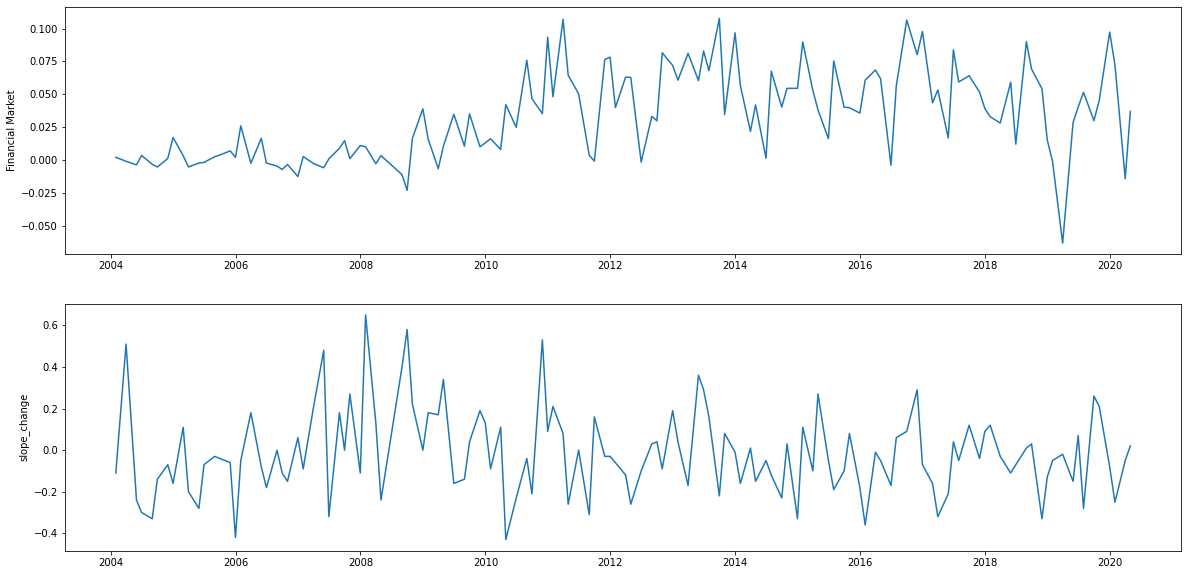

In [62]:
plt.figure()
f, axes = plt.subplots(2, 1, figsize=(20,10))
axes[0].plot(combined_df.index, combined_df['Financial Market'])
axes[0].set_ylabel('Financial Market')

axes[1].plot(combined_df.index, combined_df['slope_change'])
axes[1].set_ylabel('slope_change')

# <a name="model"></a>Modeling

In [24]:
'''
idx = []
all_files = []
for f in data_c.fileids():
    year,month,day = re.search("(\d{4})(\d{2})(\d{2})",f).groups()
    all_files.append(data_c.raw(f))
    idx.append(last_day_of_month(datetime.datetime(int(year), int(month), int(day))))
'''

x = 

indices = list(range(len(is_positive)))
minutes_train, minutes_test, is_positive_train, is_positive_test, indices_train, indices_test = train_test_split(all_files, is_positive, indices, test_size=0.3, random_state=42)
len(minutes_train)

91

## <a name="base"></a>Baseline Model

In [25]:
pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=simple_tokenizer)), ('svc', LinearSVC())])
pipe.fit(minutes_train, is_positive_train)
print("Count Train accuracy: ", pipe.score(minutes_train, is_positive_train))
print("Count Test accuracy: ", pipe.score(minutes_test, is_positive_test))

Count Train accuracy:  1.0
Count Test accuracy:  0.5128205128205128


In [26]:
pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=simple_tokenizer)), ('topics', LatentDirichletAllocation(n_components=10)), ('svc', LinearSVC())])
pipe.fit(minutes_train, is_positive_train)
print("LDA Train accuracy: ", pipe.score(minutes_train, is_positive_train))
print("LDA Test accuracy: ", pipe.score(minutes_test, is_positive_test))

LDA Train accuracy:  0.5824175824175825
LDA Test accuracy:  0.48717948717948717


## <a name="bert"></a>GloVe and BERT Embeddings 

In [42]:
vocab = set([value for valueList in tokenized_text.values for value in valueList ])
vocab.add('_UNK')
vocab.add('_PAD')

print("Size of vocab:", len(vocab))

glove_dict = dict()
for k in vocab:
    glove_dict[k] = nlp(k).vector

Size of vocab: 5796


In [43]:
idx = []
p_clean = []
for f in data_c.fileids():
    year,month,day = re.search("(\d{4})(\d{2})(\d{2})",f).groups()
    for i,p in enumerate(data_c.paras(f)):
        idx.append((year,calendar.month_abbr[int(month)],day,i)) #Year,Month,Day,Paragraph number
        flat_p = [item for sublist in p for item in sublist]
        paragraph = ' '.join(flat_p)
        p_tokenized = simple_tokenizer(paragraph)
        glove_vectors_arrays = [glove_dict[word] for word in p_tokenized]
        p_clean.append([p_tokenized, np.mean(glove_vectors_arrays, axis=0)])

df_para_glove = pd.DataFrame(data = p_clean,
                          index = pd.MultiIndex.from_tuples(idx), 
                          columns = ['paragraph', 'embeddings'])

In [44]:
df_para_glove.head()

paragraph                                         embeddings
2004 Jan 28 0  [committee, turned, discussion, economic, outl...  [-0.15773101, 0.13315131, 0.19741198, 0.188416...
            1  [economy, appeared, expanded, robust, pace, fo...  [-0.1675478, 0.31292972, 0.11367067, 0.0498928...
            2  [december, employment, report, suggested, labo...  [-0.2562988, 0.25484177, 0.110019475, 0.045327...
            3  [pace, expansion, industrial, sector, picked, ...  [-0.14535566, 0.3193455, 0.2163615, 0.00532062...
            4  [sales, light, vehicles, jumped, december, fou...  [-0.23794287, 0.28590742, 0.07534938, 0.060257...

In [45]:
idx = []
paraList = []
for f in data_c.fileids():
    year,month,day = re.search("(\d{4})(\d{2})(\d{2})",f).groups()
    for i,p in enumerate(data_c.paras(f)):
        idx.append((year,calendar.month_abbr[int(month)],day,i)) #Year,Month,Day,Paragraph number
        flat_p = [item for sublist in p for item in sublist]
        paragraph = ' '.join(flat_p)
        paraList.append([paragraph])

df_para_raw = pd.DataFrame(data = paraList,
                          index = pd.MultiIndex.from_tuples(idx), 
                          columns = ['paragraph'])


In [46]:
df_para_raw['paragraph'].to_numpy()[0]

'The Committee then turned to a discussion of the economic outlook and the conduct of monetary policy over the intermeeting period .'

In [47]:
len(df_para_raw)

5368

In [48]:
df_para_raw.paragraph.apply(len).idxmax()

('2013', 'Mar', '20', 44)

In [49]:
len(df_para_raw.loc[('2013', 'Mar', '20', 44)]['paragraph'].split(' '))

742

In [54]:
# basic pretrained model (case-insensitive)
MODEL_NAME = 'distilbert-base-uncased'
# Load pre-trained model
model = DistilBertModel.from_pretrained(MODEL_NAME)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
#samples = np.random.choice(df_para_raw['paragraph'].to_numpy(), size=5)
#samples.shape

In [ ]:

tokens = tokenizer.batch_encode_plus(df_para_raw['paragraph'].to_numpy(),
    pad_to_max_length=True, # this implements padding for different length docs
    return_tensors="pt", # returning as pytorch tensors
    max_length=512,
    truncation=True) # this BERT model has a max sequence length of 512 tokens

outputs = model(**tokens)
outputs[0][:,0].detach().numpy().shape